# Hackathon

Some utilities

## Import Utils

In [2]:
!pip install keras
!pip install tables
!pip install scikit-learn



    100% |################################| 337kB 2.8MB/s ta 0:00:01
    100% |################################| 256kB 3.8MB/s ta 0:00:01
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /root/.cache/pip/wheels/2c/f7/79/13f3a12cd723892437c0cfbde1230ab4d82947ff7b3839a4fc
Successfully built pyyaml
You are using pip version 9.0.1, however version 9.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |################################| 4.6MB 335kB/s eta 0:00:01
    100% |################################| 399kB 3.8MB/s eta 0:00:01
You are using pip version 9.0.1, however version 9.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 9.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [100]:
!pip install pickle

Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/pip/basecommand.py", line 215, in main
    status = self.run(options, args)
  File "/usr/local/lib/python3.5/dist-packages/pip/commands/install.py", line 289, in run
    delete=build_delete) as build_dir:
  File "/usr/local/lib/python3.5/dist-packages/pip/utils/build.py", line 22, in __init__
    name = os.path.realpath(tempfile.mkdtemp(prefix="pip-build-"))
  File "/usr/lib/python3.5/tempfile.py", line 497, in mkdtemp
    prefix, suffix, dir, output_type = _sanitize_params(prefix, suffix, dir)
  File "/usr/lib/python3.5/tempfile.py", line 269, in _sanitize_params
    dir = gettempdir()
  File "/usr/lib/python3.5/tempfile.py", line 435, in gettempdir
    tempdir = _get_default_tempdir()
  File "/usr/lib/python3.5/tempfile.py", line 370, in _get_default_tempdir
    dirlist)
FileNotFoundError: [Errno 2] No usable temporary directory found in ['/tmp', '/var/tmp', '/usr/tmp', '/notebooks/ChallengeH

In [101]:
import keras
import h5py as h5
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import itertools
import pickle
PATH_DATA = '/notebooks/data/full.h5'
PATH_PREDICT_WITHOUT_GT = '/notebook/data/pred_students/pred_eighties_from_half_1_without_gt.h5'
PATH_SUBMIT = 'data/submit/pred_eighties_from_half_1_AWESOMEGROUP.h5'
PATH_PREDICT_WITH_GT = 'data/pred_teachers/pred_eighties_from_half_1.h5'

In [4]:
BATCH_SIZE = 32
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
import keras.layers.normalization 
from keras.callbacks import Callback
%load_ext autoreload
%autoreload 2

In [5]:
def get_idxs(h5_path):
    f = h5.File(h5_path)
    return range(len(f['S2']))

def shuffle_idx(sample_idxs):
    return list(np.random.permutation(sample_idxs))

def split_train_val(sample_idxs, proportion): ##La deuxième partie a une taille proportion
    n_samples = len(sample_idxs)
    return sample_idxs[:int((1.-proportion)*n_samples)], sample_idxs[int((1.-proportion)*n_samples):]

def get_batch_count(idxs, batch_size):
    batch_count = int(len(idxs)//batch_size)
    remained_samples = len(idxs)%batch_size
    if remained_samples > 0:
        batch_count += 1

    return batch_count

In [6]:
def generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True : 
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X = f['S2'][batch_idxs, :,:,:]
            Y = f['TOP_LANDCOVER'][batch_idxs, :]
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), 23)

In [7]:
idxs = get_idxs(PATH_DATA)
shuffled_idxs = shuffle_idx(idxs)
train_idxs, val_idxs = split_train_val(shuffled_idxs, 0.2)

In [8]:
train_gen = generator(PATH_DATA, BATCH_SIZE, train_idxs)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen = generator(PATH_DATA, BATCH_SIZE, val_idxs)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)

In [9]:
print(train_batch_count, val_batch_count)

467456 116864


In [29]:
dset = h5.File(PATH_DATA)['TOP_LANDCOVER']
labels = dset[0:].astype(int)
data4D = h5.File(PATH_DATA)['S2']

In [37]:
dset[:].shape

(18698240, 1)

(array([5.077363e+06, 3.092702e+06, 2.168076e+06, 0.000000e+00,
        1.116208e+06, 4.820097e+06, 6.354230e+05, 3.847000e+03,
        9.030000e+04, 1.694224e+06]),
 array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21.]),
 <a list of 10 Patch objects>)

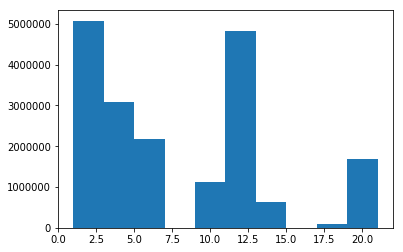

In [32]:
plt.hist(labels)

In [86]:
##Traitement des labels : 23 -> 14
unique, counts = np.unique(labels, return_counts=True)
unique = pd.DataFrame(unique)
counts = pd.DataFrame(counts)
prop = pd.DataFrame(counts/18698240*100)

labelsCountsfull = pd.concat([unique, counts,prop], axis=1, join_axes=[unique.index])
labelsCountsfull.columns = ['label','count','prop']
labelsCountsfull
minProp = 0.02
labelsCountsFiltered = labelsCountsfull[labelsCountsfull['prop']>minProp]
labelsCountsFiltered = labelsCountsFiltered.reset_index()


In [87]:
labelsCountsFiltered

,index,label,count,prop
0,0,1,3827110,20.467755
1,1,2,1250253,6.686474
2,2,3,2315736,12.384781
3,3,4,776966,4.155289
4,4,5,2167443,11.591695
5,7,10,1112499,5.949752
6,8,11,765705,4.095065
7,9,12,4054392,21.683281
8,11,14,634142,3.391453
9,12,15,3847,0.020574


In [89]:
labelsCountsFiltered.iloc[1,2]

1250253

In [93]:
equilibre = np.zeros((14,3830))

for i in range(len(labelsCountsFiltered)):
    current = labelsCountsFiltered.iloc[i,1]
    print(current)
    equilibre[i][0] = current
    equilibre[i][1:] = np.where(labels == current)[0][:3829]


1
2
3
4
5
10
11
12
14
15
17
18
19
20


In [103]:
########### SAuvegarde de la matrice entraînée
print("saving model")
f_myfile = open('equilibre.pickle', 'wb')
pickle.dump(equilibre, f_myfile)
f_myfile.close()

# Read from file
f_myfile = open('equilibre.pickle', 'rb')
Q_function = pickle.load(f_myfile)  # variables come out in the order you put them in
f_myfile.close()

saving model


# Instanciation du model

In [15]:
input_shape = (16,16,4)
model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Flatten())
model.add(Dense(23))
model.add(Activation('softmax'))

# Fit

In [16]:
# optim = keras.optimizers.Adam(lr=0.001)
optim = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(optimizer=optim,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(train_gen, steps_per_epoch=100, epochs=2, verbose=1, validation_data=val_gen, nb_val_samples=100)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=1, steps_per_epoch=100, validation_steps=100, validation_data=<generator..., epochs=2)`
  


Epoch 1/2
100/100 [==============================] - 8s 82ms/step - loss: 2.5897 - acc: 0.2666 - val_loss: 2.1668 - val_acc: 0.4178
Epoch 2/2
100/100 [==============================] - 7s 71ms/step - loss: 2.1902 - acc: 0.4113 - val_loss: 2.0360 - val_acc: 0.4428


In [17]:
data4D[1].shape

np.std(data4D[1][:][:][0])

778.1508

## Essai 1 : features moyenne + stdev ; score = 0.5045

In [ ]:

limit = int(234000*0.8)
data = np.zeros((234000,9))
for i in range(234000):
        data[i][0]= np.mean(data4D[i][:][:][0])
        data[i][1]= np.std(data4D[i][:][:][0])
        data[i][2]= np.mean(data4D[i][:][:][1])
        data[i][3]= np.std(data4D[i][:][:][1])        
        data[i][4]= np.mean(data4D[i][:][:][2])
        data[i][5]= np.std(data4D[i][:][:][2])
        data[i][6]= np.mean(data4D[i][:][:][3])
        data[i][7]= np.std(data4D[i][:][:][3])
        data[i][8]= labels[i]
        print(i)


In [42]:
dataF = pd.DataFrame(data)
dataF

,0,1,2,3,4,5,6,7,8
0,1250.578125,698.812927,1243.421875,726.362854,1250.156250,747.154114,1267.625000,734.413879,12.0
1,1592.968750,778.150818,1593.250000,787.745117,1539.906250,791.559570,1491.406250,811.838196,12.0
2,1632.718750,895.676514,1622.296875,906.153564,1630.109375,885.237976,1708.421875,877.707031,5.0
3,1370.281250,691.569458,1312.281250,705.324280,1267.296875,720.594604,1283.312500,721.255188,5.0
4,1375.859375,656.358826,1372.390625,650.016846,1335.875000,654.548096,1288.640625,669.399902,2.0
5,1226.500000,471.456024,1281.546875,557.399902,1334.843750,645.688477,1388.156250,693.514221,2.0
6,1425.718750,989.549438,1383.156250,927.540771,1366.171875,912.155457,1340.250000,865.968262,5.0
7,1391.203125,857.283691,1420.328125,896.652954,1416.375000,899.682617,1388.703125,906.276978,5.0
8,1381.312500,699.362793,1384.828125,710.943054,1395.859375,701.093628,1376.812500,673.707031,5.0
9,1166.500000,568.878967,1170.593750,559.323914,1178.062500,547.621155,1172.687500,534.595947,12.0


In [65]:
train = pd.DataFrame(dataF.iloc[0:175000,0:8])
trainLabel = dataF.iloc[0:175000,8]

test = pd.DataFrame(dataF.iloc[175000:,0:8])
testLabel = dataF.iloc[175000:,8]

In [85]:
dt_tree = RandomForestClassifier(n_estimators=100,max_depth=7,max_leaf_nodes=20)
dt_tree.fit(train,trainLabel)
print(dt_tree.feature_importances_)

[0.1835784  0.08813163 0.19068755 0.02850231 0.19827375 0.03950877
 0.20776898 0.06354862]


In [86]:
dt_tree.score(test,testLabel)

0.5033050847457627

## Prediction routines

In order to submit a result here are some gits

In [27]:
import os 
def prediction_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        X = f['S2'][batch_idxs, :,:,:]
        yield np.array(X)

def build_h5_pred_file(pred, h5_output_path):
    if os.path.exists(h5_output_path):
        os.remove(h5_output_path)
    f = h5.File(h5_output_path, 'w')
    top_landcover_submit = f.create_dataset("TOP_LANDCOVER", (len(pred), 1), maxshape=(None, 1))
    top_landcover_submit[:, 0] = pred
    f.close()
    
    return 1

In [16]:
pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
print(len(pred_idx))
pred_gen = prediction_generator(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
prediction = model.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)
print(len(prediction))
build_h5_pred_file(np.argmax(prediction, axis = 1), PATH_SUBMIT)

241700
7554/7554 [==============================] - 17s 2ms/step
241700


1

## Some ideas for monitoring

In [ ]:
def gt_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        Y = f['TOP_LANDCOVER'][batch_idxs, :]
        yield keras.utils.np_utils.to_categorical(np.array(Y), 23)

gt_gen = gt_generator(PATH_PREDICT_WITH_GT, BATCH_SIZE, pred_idx)
gt = []
for elem in gt_gen:
    gt.append(elem)
gt = np.vstack(gt)

In [41]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=7)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def clean_confusion_matrix(confusion_matrix, classes):
    real_classes = []
    for c in range(len(classes)):
        if np.sum(confusion_matrix[:,c])+np.sum(confusion_matrix[c, :]) != 0:
            real_classes.append(c)
    real_confusion_matrix = np.empty((len(real_classes), len(real_classes)))  
    for c_index in range(len(real_classes)):
        real_confusion_matrix[c_index,:] = confusion_matrix[real_classes[c_index], real_classes]
    return real_confusion_matrix, real_classes

In [ ]:
%matplotlib notebook
from sklearn.metrics import confusion_matrix
y_true = np.argmax(gt, axis=1)
y_pred = np.argmax(prediction, axis = 1)

real_cnf_matrix, real_classes = clean_confusion_matrix(confusion_matrix(y_true, y_pred, labels= range(23)), range(23))
plot_confusion_matrix(real_cnf_matrix, classes = real_classes, normalize=True)